In [1]:
import pandas as pd
import tensorflow as tf


from collections import OrderedDict
import os
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras import Sequential,Model
import tensorflow.keras as keras

import socket
if socket.gethostname() == 'marvin':
    config = ConfigProto()
    config.gpu_options.allow_growth = True
    sess = InteractiveSession(config=config)

import numpy as np
import matplotlib.pyplot as pplot
tfd = tfp.distributions
from ipywidgets import FloatSlider, IntSlider, interact, interactive
from datasets.femto_bearing import FEMTOBearingsDataset
from minigraphnets import Edge,Node, Graph

import pandas as pd


not running in colab.
Not supported! See/edit code.


## Inspect held-out set performance:


In [16]:
res = p2[['e1f' in v for v in p2.model_path.values]]
assert(len(res) == 1)
res.iloc[0]

network_size_global                                                                15
edge_node_state_size                                                              100
use_prenetworks                                                                  True
graph_function_output_activation                                                 relu
learning_rate                                                                   0.001
schedule_nnodes                                                             [1, 2, 5]
schedule_min_sep                                                             [10, 20]
nseq_length                                                                     [100]
iterations_schedule                                                               [5]
epochs                                                                            300
batch                                                                             300
rand_seed                                             

In [23]:
'rand_seed' in res.columns

True

In [30]:
import json
with open("/tmp/f",'w') as f:
    f.write(json.dumps({"a":1}, indent = 4))
    
j = json.loads(open("/tmp/f",'r').read())
j


{'a': 1}

In [33]:
    best_training_options = {'learning_rate' : 0.001,
                        'schedule_nnodes' :  [1,2,5],
                        'schedule_min_sep': [10, 20],
                        'nseq_length' : [100],
                        'iterations_schedule' : [5],
                        'epochs':300,
                        'batch' : 300,
                        'rand_seed' : 42}

    with open("training_options.json",'w') as f:
        f.write(json.dumps(best_training_options))

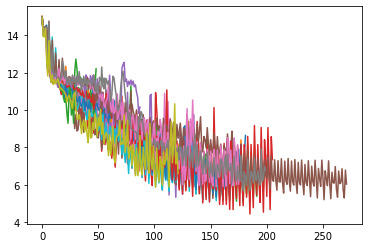

In [3]:
p2 = pd.read_pickle("models/runs_dataframe")


for v in p2['losses'].apply(lambda x : x['val_loss']):
    pplot.plot(v)

    

In [21]:
p2['min_val_error'] = p2['losses'].apply(lambda x : np.min(x['val_loss']))


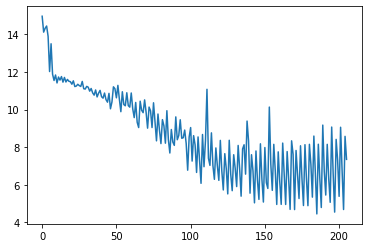

In [22]:
pplot.plot(p2.sort_values("min_val_error").iloc[0].losses['val_loss'])

In [7]:
ps = p2.sort_values("min_val_error")
ps

,network_size_global,edge_node_state_size,use_prenetworks,graph_function_output_activation,n_conv_blocks,nfilts,nfilts2,ksize,conv_block_activation_type,learning_rate,...,rand_seed,losses,model_path,training_set,validation_set,time_finished,time_started,experiment_metadata_id,experiment_metadata_desc,min_val_error
0,30,100,True,gated_tanh,2.0,10.0,10.0,2.0,leaky_relu,0.001,...,42,"{'loss': [12.960248, 12.217285, 11.370478, 10....",models/591fa5ac439e848ad2cfea5be6fc03da.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",20/07/2020 17:05:55,20/07/2020 16:54:20,1,larger graph-states seem to help. The best run...,2.539351
0,30,100,True,gated_tanh,3.0,10.0,20.0,3.0,leaky_relu,0.001,...,42,"{'loss': [12.959388, 12.196156, 11.36088, 10.6...",models/3c03c01bb2811eaadefb7c22d3e686e0.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",18/07/2020 16:27:11,18/07/2020 16:20:23,1,larger graph-states seem to help. The best run...,2.829705
0,15,30,True,gated_tanh,3.0,10.0,10.0,3.0,leaky_relu,0.001,...,42,"{'loss': [12.863186, 12.188737, 11.35577, 10.7...",models/3f33f5a99ea3a17f03d65ce71a71a69e.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",18/07/2020 16:01:42,18/07/2020 15:50:48,1,larger graph-states seem to help. The best run...,3.115369
0,15,100,True,gated_tanh,3.0,10.0,10.0,3.0,leaky_relu,0.001,...,42,"{'loss': [12.96463, 12.271865, 11.481342, 11.1...",models/312cc86741b7e6bde378a36d2dd2891e.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",18/07/2020 16:08:42,18/07/2020 16:01:49,1,larger graph-states seem to help. The best run...,3.356124
0,30,30,True,gated_tanh,2.0,10.0,10.0,2.0,leaky_relu,0.001,...,42,"{'loss': [12.795425, 12.082277, 11.170869, 10....",models/26887e4c30ee4444c0929b9001543cf7.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",20/07/2020 16:54:11,20/07/2020 16:38:17,1,larger graph-states seem to help. The best run...,3.523544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,15,30,True,gated_tanh,3.0,40.0,40.0,3.0,leaky_relu,0.001,...,42,"{'loss': [13.018785, 12.502335, 11.884106, 11....",models/ac6159ab01b06d86c7b1974a6e49eec2.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",20/07/2020 19:58:07,20/07/2020 19:56:04,1,larger graph-states seem to help. The best run...,11.188246
0,30,100,True,gated_tanh,3.0,20.0,10.0,3.0,leaky_relu,0.001,...,42,"{'loss': [13.018126, 12.540302, 11.956976, 11....",models/212b130f3be4c8abe3d776958532f358.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",20/07/2020 18:33:39,20/07/2020 18:31:56,1,larger graph-states seem to help. The best run...,11.280138
0,30,100,True,gated_tanh,3.0,20.0,40.0,3.0,leaky_relu,0.001,...,42,"{'loss': [13.02252, 12.538345, 11.927261, 11.4...",models/9f47fdfa5d854d0206519c860192d44a.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",20/07/2020 19:04:58,20/07/2020 19:02:04,1,larger graph-states seem to help. The best run...,11.313835
0,30,100,True,gated_tanh,NaN,NaN,NaN,NaN,NaN,0.001,...,42,"{'loss': [13.016337, 12.374679, 11.935427, 11....",models/1067f5ce1e91ec8aefc62fb35101e0d9.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",18/07/2020 12:24:54,18/07/2020 12:23:35,1,Figure out if gated_tanh is beneficial. See ef...,11.352514


In [48]:
ps.iloc[0]

network_size_global                                                                30
edge_node_state_size                                                              100
use_prenetworks                                                                  True
graph_function_output_activation                                           gated_tanh
n_conv_blocks                                                                       2
nfilts                                                                             10
nfilts2                                                                            10
ksize                                                                               2
conv_block_activation_type                                                 leaky_relu
learning_rate                                                                   0.001
schedule_nnodes                                                 [1, 2, 5, 10, 15, 20]
schedule_min_sep                                      

In [29]:
p2[p2['model_path'].apply(lambda x : "450e4" in x)].iloc[0]

network_size_global                                                               100
edge_node_state_size                                                               30
use_prenetworks                                                                  True
graph_function_output_activation                                           gated_tanh
n_conv_blocks                                                                       2
nfilts                                                                             10
nfilts2                                                                            10
ksize                                                                               2
conv_block_activation_type                                                 leaky_relu
learning_rate                                                                   0.001
schedule_nnodes                                                 [1, 2, 5, 10, 15, 20]
schedule_min_sep                                      

In [27]:
p2.sort_values("min_val_losses").iloc[0:10].T
    

,0,0,0,0,0,0,0,0,0,0
network_size_global,15,30,30,15,30,15,30,30,15,15
edge_node_state_size,15,30,30,100,30,30,30,30,100,30
use_prenetworks,True,True,True,True,True,True,True,True,True,True
graph_function_output_activation,gated_tanh,gated_tanh,gated_tanh,gated_tanh,gated_tanh,gated_tanh,gated_tanh,gated_tanh,gated_tanh,gated_tanh
n_conv_blocks,NaN,NaN,2,NaN,3,3,3,3,3,3
nfilts,NaN,NaN,10,NaN,20,10,40,10,40,10
nfilts2,NaN,NaN,10,NaN,10,10,10,40,40,10
ksize,NaN,NaN,2,NaN,3,3,3,3,3,3
conv_block_activation_type,NaN,NaN,leaky_relu,NaN,leaky_relu,leaky_relu,leaky_relu,leaky_relu,leaky_relu,leaky_relu
learning_rate,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001


In [23]:
['8c94ad' in p for p in p2.model_path]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False]

In [25]:
p2.iloc[-2]

network_size_global                                                                30
edge_node_state_size                                                               50
use_prenetworks                                                                  True
graph_function_output_activation                                           gated_tanh
learning_rate                                                                   0.001
schedule_nnodes                                                             [1, 2, 5]
schedule_min_sep                                                             [10, 20]
nseq_length                                                                     [100]
iterations_schedule                                                               [5]
epochs                                                                            300
batch                                                                             300
rand_seed                                             

In [19]:
for i in np.sort(p2.model_path.values):
    print(i)


models/068b2f718f350bb53cdeb418b85458ac.graphnet
models/06c4ca56c526a9025d3c51a560edddc9.graphnet
models/1067f5ce1e91ec8aefc62fb35101e0d9.graphnet
models/13e39838a68e5583ad29a4172cbdb901.graphnet
models/1b247c618589223d45cee61c4dfe8ec6.graphnet
models/1eed18169ae8d0384d1ac0f07d4a03bd.graphnet
models/20dc4cc18b7a7d16e7c5e03055543f98.graphnet
models/212b130f3be4c8abe3d776958532f358.graphnet
models/225d45932de59249df1d19d09530767a.graphnet
models/2297617152fa68609a2afe546780cc65.graphnet
models/244fd80cb9582255ebdff21b76682910.graphnet
models/26511dab266aab3aceeb0554be75898d.graphnet
models/26887e4c30ee4444c0929b9001543cf7.graphnet
models/2a4d8f7601477151096bf83067b6ceff.graphnet
models/2e416ac4e5af2db803b48b57234fd8fb.graphnet
models/2e95249f70b95cd84e77c8e7226a3d56.graphnet
models/2ea9f67c7d232807d930bfec74f9e122.graphnet
models/2fd594ee545d85b8e638534dc7e60a86.graphnet
models/312cc86741b7e6bde378a36d2dd2891e.graphnet
models/31392c7f851dfbe7e607fb6a37263e83.graphnet
models/324ad5dcab016

In [39]:
p2['min_val_losses'] = p2['losses'].apply(lambda x : np.min(x['val_loss']))
p2.sort_values('min_val_losses').iloc[0]

network_size_global                                                                30
edge_node_state_size                                                              100
use_prenetworks                                                                  True
graph_function_output_activation                                           gated_tanh
n_conv_blocks                                                                       2
nfilts                                                                             10
nfilts2                                                                            10
ksize                                                                               2
conv_block_activation_type                                                 leaky_relu
learning_rate                                                                   0.001
schedule_nnodes                                                 [1, 2, 5, 10, 15, 20]
schedule_min_sep                                      

In [7]:
p = pd.read_pickle("models/runs_dataframe")
p['min_val_loss'] = p['losses'].apply(lambda x : np.min(x['val_loss']))
path = p['model_path'].iloc[0]
model_row = p[p['model_path'] == path].iloc[0]

In [10]:
model_hash = '8c94'
p[p['model_path'].apply(lambda x : model_hash in x)].iloc[0]

network_size_global                                                                30
edge_node_state_size                                                               50
use_prenetworks                                                                  True
graph_function_output_activation                                           gated_tanh
learning_rate                                                                   0.001
schedule_nnodes                                                             [1, 2, 5]
schedule_min_sep                                                             [10, 20]
nseq_length                                                                     [100]
iterations_schedule                                                               [5]
epochs                                                                            300
batch                                                                             300
rand_seed                                             

(array([4., 4., 0., 0., 0., 0., 1., 0., 0., 1.]),
 array([ 5.1706109 ,  5.79097629,  6.41134167,  7.03170705,  7.65207243,
         8.27243781,  8.89280319,  9.51316857, 10.13353395, 10.75389934,
        11.37426472]),
 <a list of 10 Patch objects>)

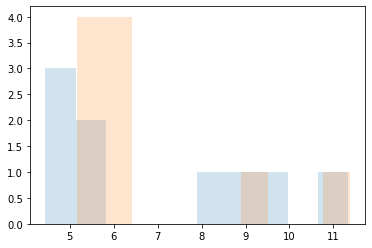

In [9]:
v1= p[p['network_size_global'] == 15]['losses'].apply(lambda x : np.min(x['val_loss']))
v2 = p[p['network_size_global'] > 15]['losses'].apply(lambda x : np.min(x['val_loss']))
pplot.hist(v1, alpha = 0.2)
pplot.hist(v2, alpha = 0.2)


In [30]:
v1= p[p['graph_function_output_activation'] == "gated_tanh"]['losses'].apply(lambda x : np.min(x['val_loss']))
v2 = p[p['network_size_global'] != "gated_tanh"]['losses'].apply(lambda x : np.min(x['val_loss']))
pplot.box(v1, alpha = 0.2, density = True)
pplot.box(v2, alpha = 0.2,density = True)


TypeError: box() got an unexpected keyword argument 'alpha'

In [58]:
column = 'graph_function_output_activation'
column = 'nseq_length'
act_vals = np.unique(p[column].values);
vv = {}
for av in act_vals : 
    v1= p[p[column] == av]['losses'].apply(lambda x : np.min(x['val_loss']))
    vv.update({av:v1})
pplot.boxplot([v.values for v in vv.values()], labels = [k for k in vv.keys()])
#pplot.boxplot(vv)
#pplot.boxplot([v1.values, v2.values], labels=["gated_tanh", "other"])
#pplot.boxplot(np.random.randn(100,1))

ValueError: Lengths must match to compare

Index(['network_size_global', 'edge_node_state_size', 'use_prenetworks',
       'graph_function_output_activation', 'learning_rate', 'schedule_nnodes',
       'schedule_min_sep', 'nseq_length', 'iterations_schedule', 'epochs',
       'batch', 'rand_seed', 'losses', 'model_path', 'training_set',
       'validation_set', 'time_finished', 'time_started',
       'experiment_metadata_id', 'experiment_metadata_desc', 'min_val_loss'],
      dtype='object')

In [56]:
p['schedule_nnodes']

0    [1, 2, 5]
0    [1, 2, 5]
0    [1, 2, 5]
0    [1, 2, 5]
0    [1, 2, 5]
0    [1, 2, 5]
0    [1, 2, 5]
0    [1, 2, 5]
0    [1, 2, 5]
0    [1, 2, 5]
0    [1, 2, 5]
0    [1, 2, 5]
0    [1, 2, 5]
0    [1, 2, 5]
0    [1, 2, 5]
0    [1, 2, 5]
0    [1, 2, 5]
0    [1, 2, 5]
0    [1, 2, 5]
Name: schedule_nnodes, dtype: object

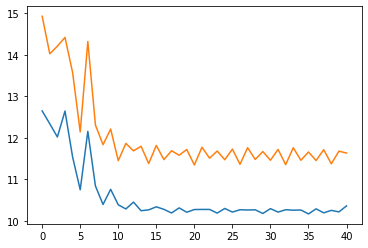

In [16]:
losses = p[p['model_path'].apply(lambda x : 'c5a4' in x)].iloc[0]['losses']
pplot.plot(losses['loss'])
pplot.plot(losses['val_loss'])

In [3]:
pp = p.set_index(["network_size_global",'edge_node_state_size']).loc[15,100].reset_index() #['model_path','min_val_loss']

/home/charilaos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


In [6]:
femto_dataset = FEMTOBearingsDataset()

training set:
01 0 2_2 1502
05 0 1_1 1802
06 0 2_7 2302
07 1 1_5 1202
08 0 3_2 1139
09 1 2_1 2002
13 1 1_7 911
15 0 1_4 2803

testing set:
16 0 1_3 2302
02 2 2_5 1637


In [4]:
model_row = pp.sort_values("min_val_loss").iloc[1]
model_row

network_size_global                                                                15
edge_node_state_size                                                              100
use_prenetworks                                                                  True
graph_function_output_activation                                                 relu
learning_rate                                                                   0.001
schedule_nnodes                                                             [1, 2, 5]
schedule_min_sep                                                             [10, 20]
nseq_length                                                                     [100]
iterations_schedule                                                               [5]
epochs                                                                            300
batch                                                                             300
rand_seed                                             

In [5]:
from graphnet_utils import GraphNetFunctionFactory, GraphNet

gn_tot = GraphNetFunctionFactory.make_from_record(model_row)
#gg = g.load(model_row['model_path'])
gn_tot.load(model_row['model_path'])

loading models/e1f68f39d80a67914e0d35510aabd94a.graphnet/core/node_function
loading models/e1f68f39d80a67914e0d35510aabd94a.graphnet/core/edge_aggregation_function
loading models/e1f68f39d80a67914e0d35510aabd94a.graphnet/core/edge_function
loading models/e1f68f39d80a67914e0d35510aabd94a.graphnet/core/node_to_prob
loading models/e1f68f39d80a67914e0d35510aabd94a.graphnet/graph_independent/node_function
path models/e1f68f39d80a67914e0d35510aabd94a.graphnet/graph_independent/edge_aggregation_function does not exist! Function edge_aggregation_function will not be constructed.
loading models/e1f68f39d80a67914e0d35510aabd94a.graphnet/graph_independent/edge_function
path models/e1f68f39d80a67914e0d35510aabd94a.graphnet/graph_independent/node_to_prob does not exist! Function node_to_prob will not be constructed.


## Plotting the held-out experiments:

NameError: name 'p' is not defined

In [7]:
self = gn_tot

def eval_graphnets(graph_data_, iterations = 5, eval_mode = "batched", return_reparametrization = True):
    """
    graph_data_  : is a "graph" object that contains a batch of graphs (more correctly, a graph tuple as DM calls it)
    iterations   : number of core iterations for the computation.
    return_distr_params : return the distribution parameters instead of the distribution itself. This is in place because of some buggy model loading (loaded models don't return distribution objects).
    """
    graph_out = self.graph_indep.graph_eval(graph_data_,eval_mode = eval_mode)
    for iterations in range(iterations):
        graph_out = self.core.graph_eval(graph_out, eval_mode = eval_mode) + graph_out # Addition adds all representations (look at implementation of "Graph")

    # Finally the node_to_prob returns a reparametrized "Gamma" distribution from only the final node state
    if not return_reparametrization:
        return self.core.node_to_prob_function(graph_out.nodes[-1].node_attr_tensor)
    else:
        v = self.core.node_to_prob_function.get_layer("output")(graph_out.nodes[-1].node_attr_tensor)
        return _instantiate_gamma(v)

def _instantiate_gamma(t, NParams_ = 1):
    return tfd.Gamma(concentration = t[...,0:NParams_], rate = t[...,NParams_:2*NParams_])

    

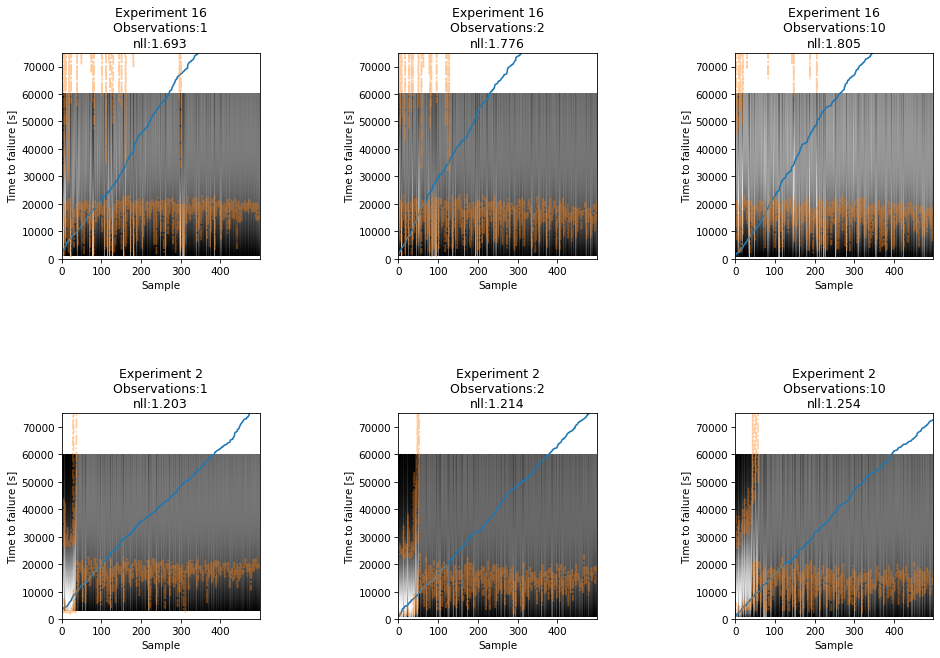

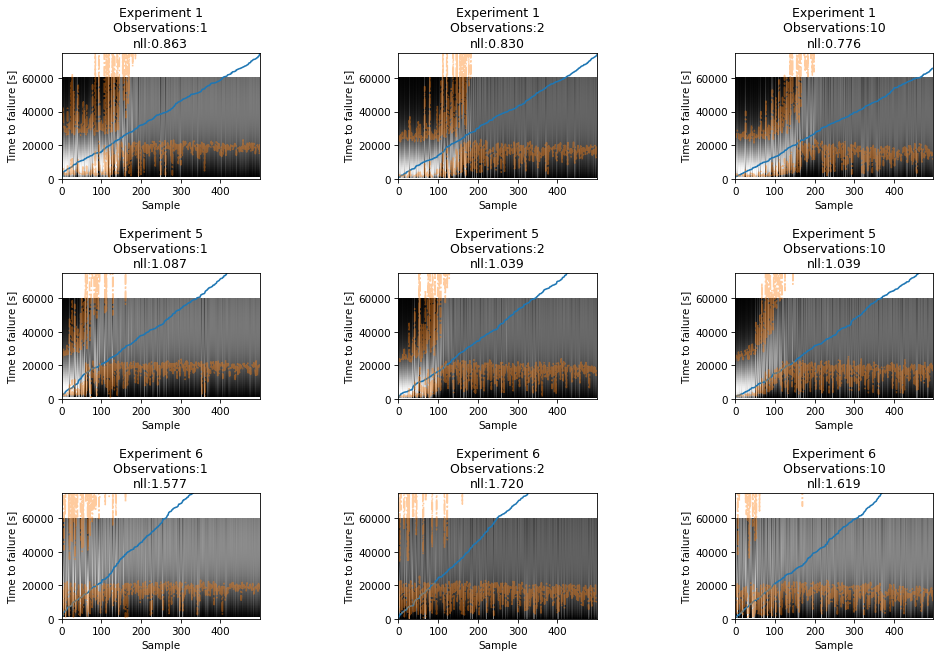

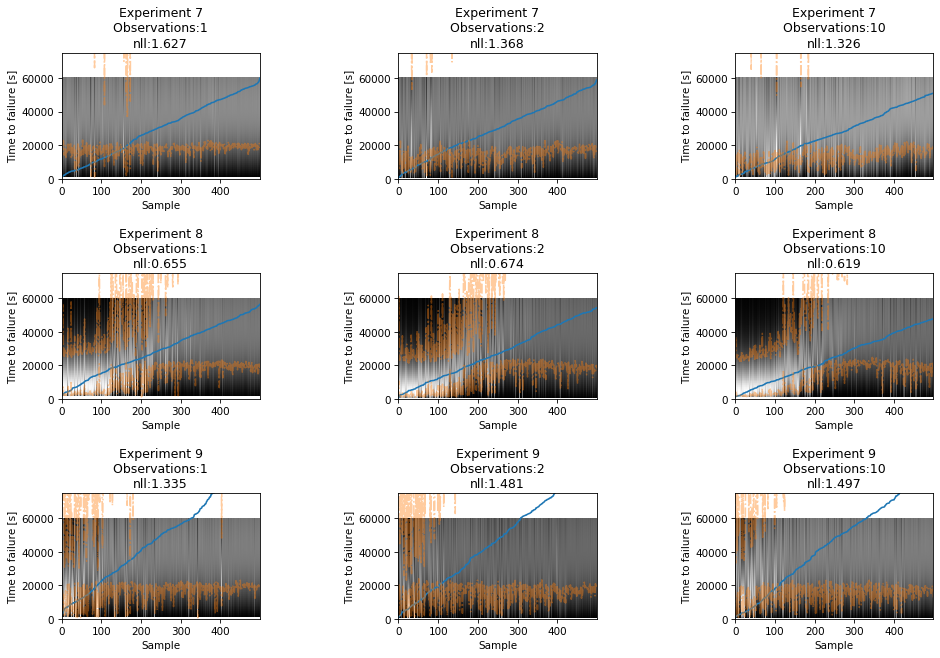

In [30]:
from utils import get_graph_data
experiments_to_plot = [1]
def plot_experiments(experiments_to_plot):
#if True:
    
    #training = inds_exp_source
    nsampled = 500

    #pplot.figure(figsize = (15,10), dpi = 150)
    
    pplot.figure(figsize = (15,10), dpi = 75)
    
    nnodes_list = [1,2,10]
    nseq_len = [100,100,200]
    minspacing= [10,10,20]
    gnsteps  = [ 5,5,5]
    
    normalization_factor_time = femto_dataset.normalization_factor_time
    kk = 0;
    for ee in experiments_to_plot:
        for nnodes, gnsteps_,nseq_,minspacing_ in zip(nnodes_list, gnsteps, nseq_len, minspacing):
            #ee = training[0]
            graphs, y_times = get_graph_data(ee, X_ = femto_dataset.X, eid_oh_ = femto_dataset.eid_oh,
                                             yrem_norm_ = femto_dataset.yrem_norm, n_sampled_graphs = nsampled, 
                                             nnodes=nnodes, fixed_spacing_indices=False, min_spacing=minspacing_,
                                             nseq_range=nseq_)
            probs = eval_graphnets(graphs,gnsteps_, eval_mode="safe")
            #eval_graphnets()
            ids_sorted = np.argsort(y_times)
            time_grid = np.linspace(np.min(y_times),np.max(y_times), 150);
            time_grid = np.linspace(np.min(y_times), 60000./normalization_factor_time, 150)
            #time_grid = np.linspace(np.min(y_times),3.5, 150);
            
            e_y = probs.mean()
            p_y = probs.prob(time_grid).numpy().T

            y_times_sorted = y_times[ids_sorted];
            pplot.subplot( len(experiments_to_plot),len(nnodes_list), kk+1)
            pplot.pcolor([r for r in range(p_y.shape[1])], time_grid*normalization_factor_time, p_y[:,ids_sorted]**0.5, cmap = "gray")
            pplot.plot(y_times_sorted  *normalization_factor_time)
            q90 = np.quantile(probs.sample(1000).numpy(),[0.05,0.95],0)[:,:,0].T[ids_sorted]

            #pplot.plot(e_y.numpy()[ids_sorted]*normalization_factor_time,'C1',label = "$E[t_f]$",alpha = 0.5)<3
            pplot.plot(q90*femto_dataset.normalization_factor_time,'C1-.', alpha = 0.4)
            pplot.ylim(0,75000)
            pplot.xlabel("Sample")
            pplot.ylabel("Time to failure [s]")

            nll = -np.mean(probs.log_prob(y_times[np.newaxis].T))

            title = "Experiment %i\n Observations:%i \nnll:%2.3f"%(ee,nnodes,nll)
            pplot.title(title)
            kk+=1
            #p_y.shape
            #pplot.show()
    pplot.subplots_adjust(hspace = 0.75, wspace = 0.7)
    #pplot.show()
    
#unseen =  inds_exp_source[3:6]#[4:7]#inds_exp_source[0:3] #inds_exp_target[0:3]

model_hash = model_row.model_path[7:-9] 

#model_row
plot_experiments(femto_dataset.inds_exp_target)
pplot.savefig(os.path.join("models/figures" , str(model_hash) + "_target.png")); pplot.show()
plot_experiments(femto_dataset.inds_exp_source[0:3])
pplot.savefig(os.path.join("models/figures" , str(model_hash) + "_source1.png")) ; pplot.show()
plot_experiments(femto_dataset.inds_exp_source[3:6])
pplot.savefig(os.path.join("models/figures" , str(model_hash) + "_source2.png")) ; pplot.show()

In [20]:
femto_dataset.exp_to_cond_dict[2]

2

In [12]:
#femto_dataset.inds_exp_source
#t = graphs.nodes[0].node_attr_tensor
#graphs.node_times[0]
graphs, y_times = get_graph_data(ee, X_ = femto_dataset.X, eid_oh_ = femto_dataset.eid_oh,
                                 yrem_norm_ = femto_dataset.yrem_norm, n_sampled_graphs = nsampled, 
                                 nnodes=nnodes, fixed_spacing_indices=False, min_spacing=minspacing_,
                                 nseq_range=nseq_)

g = graphs.copy() 
res = gn_tot.graph_indep.node_function({'timeseries_input' : g.nodes[0].node_attr_tensor,'edge_input_dummy' : np.random.randn(123,654)})
res 
#gn_tot.graph_indep.node_function.summary()

NameError: name 'ee' is not defined

In [83]:
gn_tot.graph_indep.graph_eval(g.copy())

ResourceExhaustedError: OOM when allocating tensor with shape[1000,1,2559,50] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

In [13]:
graphs, y_times = get_graph_data(ee, X_ = femto_dataset.X, eid_oh_ = femto_dataset.eid_oh,
                                 yrem_norm_ = femto_dataset.yrem_norm, n_sampled_graphs = nsampled, 
                                 nnodes=nnodes, fixed_spacing_indices=False, min_spacing=minspacing_,
                                 nseq_range=nseq_)
probs = gn_tot.eval_graphnets(graphs,gnsteps_)

In [29]:
nm = gn_tot.core.node_to_prob_function
tf.keras.Model(inputs = nm.get_layer("output").input , outputs = nm.get_layer("distribution_lambda").output)

AttributeError: Layer output is not connected, no input to return.

In [40]:
v = nm.get_layer("output")(np.random.randn(10,100))
#help(tfd.Gamma)
NParams = 1
def instantiate_gamma(t):
    return tfd.Gamma(concentration = t[...,0:NParams], rate = t[...,NParams:2*NParams])

instantiate_gamma(v).

<tfp.distributions.Gamma 'Gamma' batch_shape=[10, 1] event_shape=[] dtype=float32>

In [29]:
#gi = GraphNet.make_from_path("models/5b64ab40b6b31abd39e2b5f0baa5c02f.graphnet/graph_independent/")
p


,network_size_global,edge_node_state_size,use_prenetworks,graph_function_output_activation,learning_rate,schedule_nnodes,schedule_min_sep,nseq_length,iterations_schedule,epochs,...,rand_seed,losses,model_path,training_set,validation_set,time_finished,time_started,experiment_metadata_id,experiment_metadata_desc,min_val_loss
0,15,100,True,relu,0.001,"[1, 2, 5]","[10, 20]",[100],[5],300,...,42,"{'loss': [12.681216, 12.4196415, 12.125812, 12...",models/e1f68f39d80a67914e0d35510aabd94a.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",17/07/2020 17:36:33,17/07/2020 17:31:14,1,Figure out if gated_tanh is beneficial. See ef...,8.155869
0,15,50,True,relu,0.001,"[1, 2, 5]","[10, 20]",[100],[5],300,...,42,"{'loss': [12.678629, 12.432165, 12.104069, 12....",models/e510078b1dc351b5d7545f0845048604.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",17/07/2020 17:31:02,17/07/2020 17:20:44,1,Figure out if gated_tanh is beneficial. See ef...,5.334609
0,15,30,True,relu,0.001,"[1, 2, 5]","[10, 20]",[100],[5],300,...,42,"{'loss': [12.6748495, 12.328814, 11.921677, 12...",models/a97500725b6638661f2ae8c2916c3874.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",17/07/2020 17:20:32,17/07/2020 17:09:18,1,Figure out if gated_tanh is beneficial. See ef...,5.032773
0,30,100,True,relu,0.001,"[1, 2, 5]","[10, 20]",[100],[5],300,...,42,"{'loss': [12.679728, 12.402312, 12.053793, 12....",models/64078edc495da35313291f2d9b9adc5a.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",17/07/2020 17:09:06,17/07/2020 17:02:22,1,Figure out if gated_tanh is beneficial. See ef...,5.962331
0,30,50,True,relu,0.001,"[1, 2, 5]","[10, 20]",[100],[5],300,...,42,"{'loss': [12.714354, 12.411136, 11.961258, 12....",models/60b6fa6972645742e63b715745bdcdeb.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",17/07/2020 17:02:09,17/07/2020 16:54:33,1,Figure out if gated_tanh is beneficial. See ef...,5.331145
0,30,30,True,relu,0.001,"[1, 2, 5]","[10, 20]",[100],[5],300,...,42,"{'loss': [12.648668, 12.312098, 11.927065, 12....",models/6aab9972790ae0c0b72303a349f578ef.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",17/07/2020 16:54:21,17/07/2020 16:44:33,1,Figure out if gated_tanh is beneficial. See ef...,5.170611
0,30,30,True,relu,0.001,"[1, 2, 5]","[10, 20]",[100],[5],300,...,42,"{'loss': [12.614351, 12.295605, 11.809038, 12....",models/7345e22b4989acd8d7a5b260bdf2e788.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",17/07/2020 16:23:18,17/07/2020 16:16:27,1,Figure out if gated_tanh is beneficial. See ef...,6.398033
0,15,100,True,tanh,0.001,"[1, 2, 5]","[10, 20]",[100],[5],300,...,42,"{'loss': [12.676195, 12.412785, 12.11718, 12.6...",models/5b64ab40b6b31abd39e2b5f0baa5c02f.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",17/07/2020 16:16:14,17/07/2020 16:12:10,1,Figure out if gated_tanh is beneficial. See ef...,9.310575
0,15,50,True,tanh,0.001,"[1, 2, 5]","[10, 20]",[100],[5],300,...,42,"{'loss': [12.64727, 12.335764, 12.018303, 12.6...",models/c5a4edafec1859bccab5bd0f06e3107e.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",17/07/2020 16:11:57,17/07/2020 16:09:25,1,Figure out if gated_tanh is beneficial. See ef...,11.344099
0,15,30,True,tanh,0.001,"[1, 2, 5]","[10, 20]",[100],[5],300,...,42,"{'loss': [12.674736, 12.33642, 12.009453, 12.6...",models/a2b8dc034482061f6e6f8bab8b342730.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",17/07/2020 16:09:12,17/07/2020 15:59:55,1,Figure out if gated_tanh is beneficial. See ef...,5.131783


In [28]:
gn_tot.core.node_to_prob_function(np.random.randn(10,100,)).shape

TensorShape([100, 10, 1])

In [36]:

tf.keras.models.load_model("models/3e04b08b64f0d63891d8f72b054f63f8.graphnet/core")

OSError: SavedModel file does not exist at: models/3e04b08b64f0d63891d8f72b054f63f8.graphnet/core/{saved_model.pbtxt|saved_model.pb}

In [40]:
#tfd
help(type(gn_tot.core.node_to_prob_function.get_layer("distribution_lambda")))

Help on class DistributionLambda in module tensorflow.python.keras.saving.saved_model.load:

class DistributionLambda(RevivedLayer, tensorflow.python.keras.engine.base_layer.Layer)
 |  Keras layer loaded from a SavedModel.
 |  
 |  Method resolution order:
 |      DistributionLambda
 |      RevivedLayer
 |      tensorflow.python.keras.engine.base_layer.Layer
 |      tensorflow.python.module.module.Module
 |      tensorflow.python.training.tracking.tracking.AutoTrackable
 |      tensorflow.python.training.tracking.base.Trackable
 |      tensorflow.python.keras.utils.version_utils.LayerVersionSelector
 |      builtins.object
 |  
 |  Methods inherited from RevivedLayer:
 |  
 |  get_config(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors inherited from RevivedLayer:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  keras

In [42]:
l = gn_tot.core.node_to_prob_function.get_layer("distribution_lambda")


In [46]:

c=  l.get_config()


In [49]:

help(tfp.layers.DistributionLambda)

Help on class DistributionLambda in module tensorflow_probability.python.layers.distribution_layer:

class DistributionLambda(tensorflow.python.keras.layers.core.Lambda, tensorflow.python.module.module.Module)
 |  Keras layer enabling plumbing TFP distributions through Keras models.
 |  
 |  A `DistributionLambda` is minimially characterized by a function that returns
 |  a `tfp.distributions.Distribution` instance.
 |  
 |  Since subsequent Keras layers are functions of tensors, a `DistributionLambda`
 |  also defines how the `tfp.distributions.Distribution` shall be "concretized"
 |  as a tensor. By default, a distribution is represented as a tensor via a
 |  random draw, e.g., `tfp.distributions.Distribution.sample`. Alternatively the
 |  user may provide a `callable` taking the distribution instance and producing a
 |  `tf.Tensor`.
 |  
 |  #### Examples
 |  
 |  ```python
 |  tfk = tf.keras
 |  tfkl = tf.keras.layers
 |  tfd = tfp.distributions
 |  tfpl = tfp.layers
 |  
 |  model

[]